In [46]:
import os
import uuid
from pathlib import Path

import pandas_profiling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [7]:
input_path = Path('../data')

In [8]:
# https://numpy.org/doc/stable/reference/generated/numpy.set_printoptions.html

np.set_printoptions(suppress=True)  # Print floating point numbers using fixed point notation.

# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

# Print out the full DataFrame repr for wide DataFrames across multiple lines.
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_columns', 500)  # Set to None for unlimited number of output rows.  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)  # Set to None for unlimited number of output rows.
pd.set_option('display.width', 120)  # Width of the display in characters.

# Read in the data files

In [9]:
train = pd.read_csv(input_path / 'train.csv.gz', index_col='id')
print(train.shape)
display(train.head())

(300000, 31)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [10]:
test = pd.read_csv(input_path / 'test.csv.gz', index_col='id')
print(test.shape)
display(test.head())

(200000, 30)


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,A,F,A,A,F,BI,A,AH,AX,A,LF,A,A,A,A,B,D,D,B,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
6,A,H,C,A,E,AB,I,F,N,A,MC,A,A,A,B,D,B,D,B,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
8,A,N,C,A,F,AB,A,AH,BC,A,FN,A,A,A,B,B,D,D,B,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
9,B,L,C,A,F,BI,A,E,AX,A,HK,A,A,A,A,B,D,B,B,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
11,A,F,A,B,F,BI,A,AH,I,A,HX,A,A,A,A,D,D,D,B,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [11]:
submission = pd.read_csv(input_path / 'sample_submission.csv.gz', index_col='id')
display(submission.head())

,target
id,
5,0.5
6,0.5
8,0.5
9,0.5
11,0.5


# Balance of target

In [12]:
train['target'].value_counts(normalize=True)

0    0.73513
1    0.26487
Name: target, dtype: float64

Not 1:1 but not very imbalanced.

# EDA

In [13]:
# profile = pandas_profiling.ProfileReport(train, explorative=True)

In [14]:
# profile.to_notebook_iframe()

Observations:

* No missing cells, duplicate rows, or outliers.
* cat5, cat7, cat8, cat10 have high cardinality
* cat1, cat2, cat3, cat5, cat6, cat9 have medium cardinality
* cat0, cat11, cat12, cat13, cat14 have only two categories. cat0 and cat14 are more balanced.
* cat15, cat16, cat17, cat18 have 4 but could be made into binary unless the individual categories have high correlation with target.

## EDA of Continuous Variables

In [15]:
cont_vars = [c for c in train.columns if c.startswith('cont')]
cont_vars

['cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10']

In [16]:
# for cont_var in cont_vars:
#     sns.histplot(
#         x=cont_var,
#         data=train,
#         hue='target',
#     );
#     plt.show();

In [17]:
# pd.plotting.scatter_matrix(train, alpha=0.2);

In [18]:
# corrDf = train[cont_vars + ['target']].corr().abs()

# for col in corrDf.columns:
#     corrDf.loc[col, col] = 0

# idxmax = corrDf.idxmax(axis='columns')
# max_ = corrDf.max(axis='columns')

# (
#     pd.DataFrame(
#         index=corrDf.index,
#         data={
#             'idxmax': idxmax,
#             'max': max_,
#         },
#     )
#     .sort_values(
#         by=[
#             'max',
#         ],
#         ascending=False,
#     )
# )

Observations:

* Cont1 and Cont2 are highly dependent on each other! Better to remove one of them, or take the difference between them as a feature.
* Cont0 and Cont10 are also highly dependent on each other, as are count7 and count10.


## EDA of Categorical Variables

In [19]:
cat_vars = [c for c in train.columns if c.startswith('cat')]
cat_vars

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18']

In [20]:
for cat_var in cat_vars:
    train[cat_var] = train[cat_var].astype('category')

In [21]:
# for cat_var in cat_vars:
#     sns.catplot(x=cat_var, y="target", data=train, kind="bar",);
#     plt.show();

# Transformations

## Transform Continuous Variables

In [22]:
def subtractCorrelated(df):
    df['cont1m2'] = df['cont1'] - df['cont2']
    df['cont1m10'] = df['cont1'] - df['cont10']
    df['cont0m7'] = df['cont0'] - df['cont7']
    df['cont1m8'] = df['cont1'] - df['cont8']
    df = (
        df
        .drop(
            columns=[
                'cont2',
                'cont10',
                'cont7',
                'cont8'
            ]
        )
    )

    return df

In [23]:
# train = subtractCorrelated(train)
# test = subtractCorrelated(test)

In [24]:
train.shape, test.shape

((300000, 31), (200000, 30))

In [25]:
# corrDf = train[cont_vars + ['target']].corr().abs()

# for col in corrDf.columns:
#     corrDf.loc[col, col] = 0

# idxmax = corrDf.idxmax(axis='columns')
# max_ = corrDf.max(axis='columns')

# display(
#     pd.DataFrame(
#         index=corrDf.index,
#         data={
#             'idxmax': idxmax,
#             'max': max_,
#         },
#     )
#     .sort_values(
#         by=[
#             'max',
#         ],
#         ascending=False,
#     )
# )

# display(corrDf['target'])

## Transform Categorical Variables

In [26]:
def manuallyHandleCategorical(df):
    # cat15, cat16, cat17, cat18 have 4 but could be made into binary.

    mask = df['cat15'].isin(['B', 'D'])
    df.loc[~mask, 'cat15'] = 'B'  # Replace others with mode.

    mask = df['cat16'].isin(['B', 'D'])
    df.loc[~mask, 'cat16'] = 'D'  # Replace others with mode.

    mask = df['cat17'].isin(['B', 'D'])
    df.loc[~mask, 'cat17'] = 'D'  # Replace others with mode.

    mask = df['cat18'].isin(['B', 'D'])
    df.loc[~mask, 'cat18'] = 'D'  # Replace others with mode.
    
    # cat1, cat2, cat3, cat5, cat6, cat9 have medium cardinality

    col = 'cat1'
    s = ['I', 'F', 'K', 'L', 'H']
    mode = 'I'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat2'
    s = ['A', 'C', 'D', 'G']
    mode = 'A'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat3'
    s = ['A', 'B', 'C']
    mode = 'A'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat5'
    s = ['BI', 'AB']
    mode = 'BI'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat6'
    s = ['A', 'C', 'E']
    mode = 'A'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat9'
    s = ['A', 'C', 'E']
    mode = 'A'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat7'
    s = ['AH', 'E', 'AS', 'J', 'AN', 'U',]
    mode = 'AH'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat8'
    s = ['BM', 'AE', 'AX', 'Y', 'H',]
    mode = 'BM'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

    col = 'cat10'
    s = ['DJ', 'HK', 'DP', 'GS',]
    mode = 'DJ'
    mask = df[col].isin(s)
    df.loc[~mask, col] = mode  # Replace others with mode.

In [27]:
# train = manuallyHandleCategorical(train)
# test = manuallyHandleCategorical(test)

In [28]:
train.shape, test.shape

((300000, 31), (200000, 30))

# Train

## Pull out the target, and make a validation split

In [29]:
target = train.pop('target')

In [30]:
train.shape, test.shape

((300000, 30), (200000, 30))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.25)

In [32]:
def getOHE():
    return OneHotEncoder(sparse=False)

In [33]:
def getLE():
    return LabelEncoder()

In [34]:
enc = getLE()
# enc = getOHE()

In [35]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for c in X_train_enc[cat_vars].columns:
    enc.fit(list(X_train_enc[c].values) + list(X_test_enc[c].values))
    X_train_enc[c] = enc.transform(X_train_enc[c].values)
    X_test_enc[c] = enc.transform(X_test_enc[c].values)

In [36]:
X_train.shape, X_train_enc.shape, X_test.shape, X_test_enc.shape

((225000, 30), (225000, 30), (75000, 30), (75000, 30))

In [37]:
X_train_enc.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16814,0,10,0,3,4,33,0,30,4,9,69,0,0,0,0,1,3,3,1,0.291524,0.345611,0.341304,0.560810,0.810968,0.732234,0.449314,0.390780,0.435947,0.314461,0.335669
329821,1,8,0,1,3,2,0,8,57,0,63,0,0,0,0,1,3,3,3,0.285630,0.217443,0.285977,0.285826,0.614740,0.104228,0.392326,0.241739,0.264836,0.261100,0.304086
103492,0,8,2,0,4,33,2,46,23,0,75,0,0,0,1,0,3,3,1,0.446771,0.208368,0.317481,0.343184,0.299323,0.158725,0.476149,0.318302,0.295236,0.327061,0.254257
13022,0,7,0,10,7,33,4,39,48,0,163,0,0,0,1,3,1,1,2,0.581347,0.797629,0.954224,0.209621,0.787311,0.780718,0.947566,0.433113,0.674925,0.549205,0.531582
138479,0,8,9,0,4,33,4,0,51,0,69,0,0,0,1,1,1,3,1,0.284765,0.324467,0.357042,0.602812,0.235728,0.278267,0.491750,0.308553,0.343072,0.352830,0.387701


In [38]:
def getRFC():
    return RandomForestClassifier(n_estimators=200, max_depth=7, n_jobs=-1, verbose=1)

In [39]:
def getXgb():
    return xgb.XGBClassifier(
        n_jobs=-1,
        random_state=0,
        use_label_encoder=False,
    )

In [40]:
def getRsXgb():
    params = {
        'min_child_weight': [1, 4],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 6, 8],
    }
    
    clf = xgb.XGBClassifier(
        n_jobs=-1,
        random_state=0,
        use_label_encoder=False,
    )
    
    return RandomizedSearchCV(  # FIXME: Try new one?
        clf,
        param_distributions=params,
        scoring='roc_auc',  # FIXME: Try f1, f1_weighted?
        random_state=0,
        n_jobs=-1,
        verbose=2,
    )

In [41]:
%%time
# clf = getRFC()
clf = getRsXgb()
clf.fit(X_train_enc, y_train)
y_pred = clf.predict_proba(X_test_enc)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, y_pred)
print(f'{score:0.5f} v 0.88962 reference value')  # New value ?!

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:36:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.89118 v 0.88962 reference value
CPU times: user 2min 21s, sys: 2.15 s, total: 2min 24s
Wall time: 9min 24s


## Let's take a look at how the model predicted the various classes

The graph below shows that the model does well with most of the negative observations, but struggles with many of the positive observations.

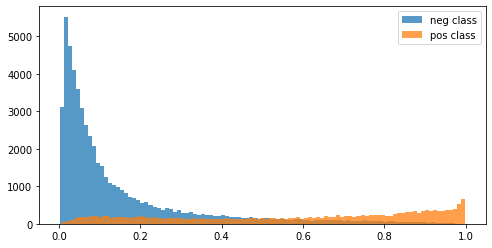

In [42]:
plt.figure(figsize=(8,4))
plt.hist(y_pred[np.where(y_test == 0)], bins=100, alpha=0.75, label='neg class')
plt.hist(y_pred[np.where(y_test == 1)], bins=100, alpha=0.75, label='pos class')
plt.legend()
plt.show()

# Train it on all the data and create submission

In [43]:
# enc = getOHE()
enc = getLE()

In [44]:
train_enc = train.copy()
test_enc = test.copy()

for c in train_enc[cat_vars].columns:
    enc.fit(list(train_enc[c].values) + list(test_enc[c].values))
    train_enc[c] = enc.transform(train_enc[c].values)
    test_enc[c] = enc.transform(test_enc[c].values)

In [45]:
%%time
# clf = getRFC()
clf = getRsXgb()
clf.fit(train_enc, target)
submission['target'] = clf.predict_proba(test_enc)[:, 1]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:48:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3min 11s, sys: 3 s, total: 3min 14s
Wall time: 12min 28s


In [48]:
filename = f'submission_{uuid.uuid4()}.csv'
submission.to_csv(input_path / filename)
filename

'submission_e85c53b1-7ec4-4f32-aabd-965587ca7b0a.csv'